# **뉴스 기사 분류 : 다중 분류 문제**
---
- 로이터 뉴스 data set을 46개의 토픽으로 분류
- 각 데이터 sample이 하나의 범주로 분류 -> 단일 레이블 다중 분류 문제

## **로이터 데이터셋 로드**
- 1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합
- 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋
- 46개의 토픽, 토픽별 데이터 갯수는 서로 상이
- 각 토픽은 훈련 세트에 최소 10개의 샘플 갖고 있음

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


num_words=10000 매개변수는 데이터에서 가장 자주 등장하는 단어 10,000개로 제한
총 8.982개의 훈련 샘플과 2,246개의 테스트 샘플



In [2]:
print(len(train_data), len(test_data))

8982 2246


각 샘플은 정수 리스트(단어 인덱스)

In [3]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


## **데이터 준비**

데이터를 벡터로 변환

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # np.zeros()의 input은 튜플 형태
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 ont-hot encoding

In [21]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## **모델 구성**

- IMDB와의 차이는 출력 클래스 갯수 2개 -> 46개 (출력공간의 차원이 훨씬 커짐)
- Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용 가능
- 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없음
- 즉, 각 층은 잠재적으로 정보의 병목이 될 수 있음
- 2개의 출력 클래스를 가진 IMDB에선 16차원 중간층을 사용했지만 이는 46개의 클래스를 구분하기에는 제약이 많음(규모가 작은 층은 유용한 정보를 잃게 되는 정보의 병목처럼 동작할 수 있음)
- 따라서, 이 예제에선 64개의 유닛 사용

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

- 적절한 손실 함수는 `categorical_crossentropy`
- 이 함수는 두 확률 분포 사이의 거리 측정
- 여기선 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사잉의 거리 측정
- 이를 최소화해서 진짜 레이블에 가까운 출력을 내도록 학습

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

## **훈련 검증**
- 훈련 데이터에서 1,000개의 샘플을 따로 떼어 검증 세트로 사용

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20번의 에폭으로 모델을 훈련

In [15]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 4s 33ms/step - loss: 2.5575 - acc: 0.5309 - val_loss: 1.6715 - val_acc: 0.6320
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.3738 - acc: 0.7072 - val_loss: 1.2789 - val_acc: 0.7120
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.0173 - acc: 0.7840 - val_loss: 1.1066 - val_acc: 0.7590
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8006 - acc: 0.8314 - val_loss: 1.0125 - val_acc: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.6365 - acc: 0.8672 - val_loss: 0.9798 - val_acc: 0.7820
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.5042 - acc: 0.8956 - val_loss: 0.9316 - val_acc: 0.8060
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4087 - acc: 0.9156 - val_loss: 0.8805 - val_acc: 0.8160
Epoch 8/20
16/16 [==============================] - 0s 16ms/step - loss: 0.3266 - a

손실과 정확도 그래프

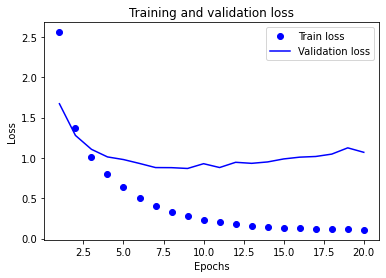

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

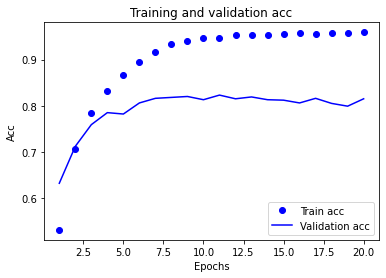

In [19]:
plt.clf() # 그래프 초기화

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(loss)+1)

plt.plot(epochs, acc, 'bo', label='Train acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

이 모델은 대략 9번째 에폭 이후에 과대적합 시작 -> 9번의 에폭으로 새로운 모델을 훈련하고 테스트 세트에서 평가해보자!

In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 33ms/step - loss: 2.5191 - acc: 0.5189 - val_loss: 1.6677 - val_acc: 0.6540
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.3689 - acc: 0.7121 - val_loss: 1.2816 - val_acc: 0.7190
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 1.0293 - acc: 0.7771 - val_loss: 1.1257 - val_acc: 0.7560
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.8168 - acc: 0.8272 - val_loss: 1.0311 - val_acc: 0.7860
Epoch 5/9
16/16 [==============================] - 0s 18ms/step - loss: 0.6546 - acc: 0.8663 - val_loss: 0.9571 - val_acc: 0.7960
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5212 - acc: 0.8918 - val_loss: 0.9255 - val_acc: 0.8070
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4187 - acc: 0.9119 - val_loss: 0.8904 - val_acc: 0.8130
Epoch 8/9
16/16 [==============================] - 0s 17ms/step - loss: 0.3395 - acc: 0.92

- 대략 77%의 정확도를 달성
- 균형 잡힌 이진 분류 문제에서 무작위로 분류하면 50%의 정확도를 달성
- 이 문제는 불균형한 데이터셋을 사용하므로 무작위 분류시 19% 정도의 정확도를 달성
- 여기에 비하면 꽤 좋은 결과를 내는 편

In [26]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1803205699020481

## **새로운 데이터에 대해 예측하기**
- predict 메서드는 46개 토픽에 대한 확률 분포를 반환

In [29]:
predictions = model.predict(x_test)

In [32]:
predictions

array([[1.4692800e-04, 1.4064768e-03, 1.1274318e-03, ..., 5.2611082e-05,
        3.4735916e-05, 4.4869899e-05],
       [1.5208399e-02, 6.1606649e-02, 5.7741728e-02, ..., 5.9246109e-04,
        2.5110532e-04, 4.7756981e-05],
       [1.4114424e-02, 7.5093746e-01, 5.0038099e-03, ..., 8.0471556e-04,
        2.9013446e-04, 4.9618713e-04],
       ...,
       [1.4307011e-04, 2.3093955e-03, 9.3752175e-04, ..., 7.7028613e-05,
        1.1617316e-04, 2.9264114e-04],
       [6.4192311e-04, 2.7820928e-02, 5.4112077e-03, ..., 3.7387267e-04,
        3.5562200e-04, 3.1773193e-04],
       [9.5878858e-03, 7.3890102e-01, 1.6797788e-02, ..., 1.2005487e-03,
        5.4192037e-04, 3.2268112e-04]], dtype=float32)

In [30]:
predictions[0].shape

(46,)

In [31]:
np.sum(predictions[0])

1.0000001

In [33]:
np.argmax(predictions[0])

3

## **충분히 큰 중간층을 두어야 하는 이유**
- 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46 차원보다 많이 적어서는 안됨
- 4차원을 두면 정보의 병목이 어떻게 나타나는지 살펴보자

In [35]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 31ms/step - loss: 3.6880 - accuracy: 0.0852 - val_loss: 3.5100 - val_accuracy: 0.1700
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 3.3552 - accuracy: 0.2157 - val_loss: 3.2347 - val_accuracy: 0.2300
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 3.0440 - accuracy: 0.2403 - val_loss: 2.9477 - val_accuracy: 0.2310
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 2.7241 - accuracy: 0.4178 - val_loss: 2.6560 - val_accuracy: 0.5270
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 2.3978 - accuracy: 0.5558 - val_loss: 2.3627 - val_accuracy: 0.5590
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 2.0926 - accuracy: 0.5765 - val_loss: 2.1194 - val_accuracy: 0.5690
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 1.8467 - accuracy: 0.5897 - val_loss: 1.9241 - val_accuracy: 0.5820
Epoch 8/20
16

검증 정확도 81% -> 64%로 감소. 이런 손실의 원인은 대게 많은 정보(46차원)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문에 발생

## **정확도 개선(기존 test acc=0.7845)**
- 128개의 은닉 유닛 사용
- 은닉층을 3개로 추가
- Dropout 사용
- optimizer 변경
- Batch normalization
- 가중치 초기화(Xavier, He)

## **model1 : 128개의 은닉 유닛 사용**


- test acc : 0.7845 -> 0.7983로 약 0.0138 증가

In [40]:
model1 = models.Sequential()
model1.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(46, activation='softmax'))

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model1.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model1.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 30ms/step - loss: 2.2141 - acc: 0.5455 - val_loss: 1.3943 - val_acc: 0.6940
Epoch 2/9
16/16 [==============================] - 0s 18ms/step - loss: 1.1229 - acc: 0.7608 - val_loss: 1.1008 - val_acc: 0.7620
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 0.7869 - acc: 0.8315 - val_loss: 1.0270 - val_acc: 0.7840
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5686 - acc: 0.8817 - val_loss: 0.8932 - val_acc: 0.8180
Epoch 5/9
16/16 [==============================] - 0s 18ms/step - loss: 0.4244 - acc: 0.9094 - val_loss: 0.8857 - val_acc: 0.8150
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.3089 - acc: 0.9300 - val_loss: 0.9215 - val_acc: 0.8000
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.2460 - acc: 0.9424 - val_loss: 0.8965 - val_acc: 0.8090
Epoch 8/9
16/16 [==============================] - 0s 18ms/step - loss: 0.2099 - acc: 0.94

## **model2 : 은닉층 3개 사용**

- test acc : 0.7845 -> 0.7765로 약 0.0008 감소

In [43]:
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model2.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model2.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 32ms/step - loss: 2.7488 - acc: 0.4327 - val_loss: 1.7734 - val_acc: 0.5780
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.4772 - acc: 0.6776 - val_loss: 1.3305 - val_acc: 0.7060
Epoch 3/9
16/16 [==============================] - 0s 17ms/step - loss: 1.0942 - acc: 0.7611 - val_loss: 1.1466 - val_acc: 0.7520
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.8637 - acc: 0.8158 - val_loss: 1.0377 - val_acc: 0.7840
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6790 - acc: 0.8518 - val_loss: 1.0106 - val_acc: 0.7920
Epoch 6/9
16/16 [==============================] - 0s 16ms/step - loss: 0.5462 - acc: 0.8765 - val_loss: 0.9624 - val_acc: 0.8080
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4261 - acc: 0.9069 - val_loss: 0.9814 - val_acc: 0.7980
Epoch 8/9
16/16 [==============================] - 0s 17ms/step - loss: 0.3539 - acc: 0.92

## **model3 : Dropout 적용**

- test acc : 0.7845 -> 0.7850로 약 0.0005 증가 

In [52]:
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model3.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model3.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 31ms/step - loss: 2.6775 - acc: 0.4946 - val_loss: 1.7471 - val_acc: 0.6240
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.5710 - acc: 0.6637 - val_loss: 1.3573 - val_acc: 0.7010
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 1.2545 - acc: 0.7190 - val_loss: 1.2007 - val_acc: 0.7350
Epoch 4/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0672 - acc: 0.7583 - val_loss: 1.1034 - val_acc: 0.7600
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.9213 - acc: 0.7892 - val_loss: 1.0406 - val_acc: 0.7800
Epoch 6/9
16/16 [==============================] - 0s 16ms/step - loss: 0.8083 - acc: 0.8117 - val_loss: 1.0083 - val_acc: 0.7890
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.7099 - acc: 0.8376 - val_loss: 0.9630 - val_acc: 0.8040
Epoch 8/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6184 - acc: 0.85

## **model4 : optimizer 변경(rmsprop -> adam)**

- test acc : 0.7845 -> 0.7858로 약 0.0013 증가

In [56]:
model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(46, activation='softmax'))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model4.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model4.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 31ms/step - loss: 3.2305 - acc: 0.3906 - val_loss: 2.4715 - val_acc: 0.5450
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.9257 - acc: 0.6295 - val_loss: 1.5824 - val_acc: 0.6600
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 1.2979 - acc: 0.7264 - val_loss: 1.2410 - val_acc: 0.7180
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.9908 - acc: 0.7780 - val_loss: 1.0904 - val_acc: 0.7640
Epoch 5/9
16/16 [==============================] - 0s 16ms/step - loss: 0.7764 - acc: 0.8332 - val_loss: 1.0058 - val_acc: 0.7820
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6079 - acc: 0.8717 - val_loss: 0.9358 - val_acc: 0.8050
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4721 - acc: 0.9028 - val_loss: 0.9028 - val_acc: 0.8140
Epoch 8/9
16/16 [==============================] - 0s 16ms/step - loss: 0.3718 - acc: 0.92

## **model5 : Batch normalization**

- test acc : 0.7845->0.7538로 약 0.0307 감소

In [59]:
model5 = models.Sequential()
model5.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(46, activation='softmax'))

model5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model5.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model5.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 33ms/step - loss: 2.1696 - acc: 0.5774 - val_loss: 3.4035 - val_acc: 0.7100
Epoch 2/9
16/16 [==============================] - 0s 18ms/step - loss: 0.9255 - acc: 0.8472 - val_loss: 3.2627 - val_acc: 0.7460
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 0.5409 - acc: 0.9143 - val_loss: 3.1294 - val_acc: 0.7580
Epoch 4/9
16/16 [==============================] - 0s 18ms/step - loss: 0.3471 - acc: 0.9421 - val_loss: 2.9541 - val_acc: 0.7600
Epoch 5/9
16/16 [==============================] - 0s 19ms/step - loss: 0.2471 - acc: 0.9518 - val_loss: 2.8083 - val_acc: 0.7490
Epoch 6/9
16/16 [==============================] - 0s 18ms/step - loss: 0.1972 - acc: 0.9525 - val_loss: 2.6523 - val_acc: 0.7460
Epoch 7/9
16/16 [==============================] - 0s 18ms/step - loss: 0.1684 - acc: 0.9544 - val_loss: 2.4460 - val_acc: 0.7600
Epoch 8/9
16/16 [==============================] - 0s 19ms/step - loss: 0.1452 - acc: 0.95

## **model6 : He 가중치 초기화**

- test acc : 0.7845 -> 0.7876로 약 0.0031 증가

In [60]:
model6 = models.Sequential()
model6.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(10000,)))
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dense(46, activation='softmax'))

model6.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model6.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model6.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 53ms/step - loss: 2.6729 - acc: 0.5231 - val_loss: 1.7464 - val_acc: 0.6260
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.4211 - acc: 0.7065 - val_loss: 1.3272 - val_acc: 0.7220
Epoch 3/9
16/16 [==============================] - 0s 19ms/step - loss: 1.0483 - acc: 0.7761 - val_loss: 1.1340 - val_acc: 0.7610
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.8224 - acc: 0.8271 - val_loss: 1.0411 - val_acc: 0.7880
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6455 - acc: 0.8668 - val_loss: 0.9855 - val_acc: 0.8040
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5182 - acc: 0.8945 - val_loss: 0.9390 - val_acc: 0.8120
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4165 - acc: 0.9163 - val_loss: 0.9191 - val_acc: 0.8180
Epoch 8/9
16/16 [==============================] - 0s 16ms/step - loss: 0.3398 - acc: 0.93

## **model7 : Xavier 가중치 초기화**

- test acc : 0.7845 -> 0.7872로 약 0.0027 증가

In [61]:
model7 = models.Sequential()
model7.add(layers.Dense(64, activation='relu', kernel_initializer='glorot_normal', input_shape=(10000,)))
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dense(46, activation='softmax'))

model7.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model7.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model7.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 30ms/step - loss: 2.4721 - acc: 0.5427 - val_loss: 1.6947 - val_acc: 0.6390
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.3822 - acc: 0.7067 - val_loss: 1.3163 - val_acc: 0.7150
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0346 - acc: 0.7790 - val_loss: 1.1527 - val_acc: 0.7430
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.8213 - acc: 0.8282 - val_loss: 1.0349 - val_acc: 0.7720
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6514 - acc: 0.8687 - val_loss: 0.9647 - val_acc: 0.7930
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5165 - acc: 0.8953 - val_loss: 0.9184 - val_acc: 0.8130
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4172 - acc: 0.9114 - val_loss: 0.8799 - val_acc: 0.8200
Epoch 8/9
16/16 [==============================] - 0s 17ms/step - loss: 0.3380 - acc: 0.92

## **Custom model(종합)**

- test acc : 0.7845 -> 0.8001로 0.0156 증가

In [62]:
model_custom = models.Sequential()
model_custom.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(10000,)))
model_custom.add(layers.Dropout(0.2))
model_custom.add(layers.Dense(128, activation='relu'))
model_custom.add(layers.Dropout(0.2))
model_custom.add(layers.Dense(46, activation='softmax'))

model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_custom.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model_custom.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 33ms/step - loss: 2.9886 - acc: 0.4307 - val_loss: 1.9923 - val_acc: 0.5720
Epoch 2/9
16/16 [==============================] - 0s 18ms/step - loss: 1.6845 - acc: 0.6278 - val_loss: 1.3977 - val_acc: 0.6860
Epoch 3/9
16/16 [==============================] - 0s 17ms/step - loss: 1.2330 - acc: 0.7236 - val_loss: 1.1785 - val_acc: 0.7440
Epoch 4/9
16/16 [==============================] - 0s 18ms/step - loss: 0.9700 - acc: 0.7850 - val_loss: 1.0573 - val_acc: 0.7860
Epoch 5/9
16/16 [==============================] - 0s 18ms/step - loss: 0.7648 - acc: 0.8330 - val_loss: 0.9631 - val_acc: 0.8100
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5995 - acc: 0.8672 - val_loss: 0.9094 - val_acc: 0.8170
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.4634 - acc: 0.8989 - val_loss: 0.8797 - val_acc: 0.8190
Epoch 8/9
16/16 [==============================] - 0s 18ms/step - loss: 0.3703 - acc: 0.91

## **결론**
- test 정확도가 증가한 case는 다음과 같다.
  - `128개의 은닉 유닛` 사용
  - `dropout` 적용(rate = 0.2)
  - `adam` optimizer
  - `He 초기값` 사용
- 위의 변경점들을 종합한 custom model의 최종 test 정확도는 기존 모델의 0.7845에서 0.8001로 0.0156 증가하였다.
- 결과적으로 최종 test accuracy는 80%로 기존 original 모델의 78%보다 **약 2% 상승**하였다.